# Load data and import modules

In [2]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

--2023-12-03 10:23:30--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  15.3MB/s    in 0.3s    

2023-12-03 10:23:30 (15.3 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.ba

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import check_random_state
import random
import os

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    check_random_state(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# attempt to make it deterministic
seed_everything()

## Load data files

In [4]:
from pathlib import Path

# define path and columns
data_folder = Path("./ml-100k")
data_col_names = ["user_id", "movie_id", "rating", "timestamp"]
user_data_col_names = ["user_id", "age", "gender", "occupation", "zip_code"]
movie_data_col_names = ["movie_id", "title", "release_date", "video_release_data", "url"] + [f"genre_{i}" for i in range(19)]

In [7]:
from sklearn.model_selection import train_test_split

data = pd.read_csv(str(data_folder / "u.data"), sep="\t", names=data_col_names, encoding='latin-1')
user_data = pd.read_csv(str(data_folder / "u.user"), sep="|", names=user_data_col_names, encoding='latin-1')
movie_data = pd.read_csv(str(data_folder / "u.item"), sep="|", names=movie_data_col_names, encoding='latin-1')

# Recommender System Construction

## Recommender design

In [35]:
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler


class CollaborativeFilteringRecSys:
    def __init__(self, pca_var=0.99, knn_neighbors=450):
        self.pca_var = pca_var
        self.knn_neighbors = knn_neighbors
        self.distances = None
        self.neighbors = None
        self.rating_matrix = None

    def fit(self, train_df: pd.DataFrame, movie_data: pd.DataFrame = None):
        self.rating_matrix = train_df.pivot(index="movie_id", columns="user_id", values="rating").fillna(0)
        if movie_data is None:
            total_item_matrix = self.rating_matrix
        else:
            total_item_matrix = self.rating_matrix.merge(movie_data, on="movie_id")
            total_item_matrix = total_item_matrix.drop(columns=["movie_id", "title", "release_date", "video_release_data", "url"])

        pipeline = Pipeline([("scale", MinMaxScaler((-1, 1))), ("pca", PCA(n_components=self.pca_var))])
        X_train = pipeline.fit_transform(total_item_matrix.values)
        knn = NearestNeighbors(metric="cosine")
        knn.fit(X_train)
        self.distances, self.neighbors = knn.kneighbors(X_train, n_neighbors=self.knn_neighbors)

    def calculate_rating(self, neighbors_dists, user_rating_history):
        # calculate projected rating
        sum_sim = 0
        weighted_sum_ratings = 0
        for movie_dist, movie_index in neighbors_dists:
            cur_movie_id = movie_index + 1
            sim = 1 - movie_dist
            sum_sim += sim
            weighted_sum_ratings += user_rating_history[cur_movie_id] * sim

        if weighted_sum_ratings == 0:
            return 0
        return weighted_sum_ratings / sum_sim


    def predict_movie_rating(self, user_id, movie_id, rated_neighbors):
        movie_index = self.rating_matrix.index.tolist().index(movie_id)
        movie_dists = self.distances[movie_index].tolist()
        movie_neighbors = self.neighbors[movie_index].tolist()

        if movie_index in movie_neighbors:
            cur_ind = movie_neighbors.index(movie_index)
            movie_dists.pop(cur_ind)
            movie_neighbors.pop(cur_ind)

        user_rating_history = self.rating_matrix[user_id]
        seen_movies = set(user_rating_history[user_rating_history != 0].index)
        neighbors_dists = list(filter(lambda x: (x[1] + 1) in seen_movies,
                                    zip(movie_dists, movie_neighbors)))[:rated_neighbors]

        return self.calculate_rating(neighbors_dists, user_rating_history)


    def predict_unseen(self, user_id, verbose=True, rated_neighbors=5):
        user_rating_history = self.rating_matrix[user_id]
        unseen_movies = user_rating_history[user_rating_history == 0].index

        ratings = []
        if verbose:
            pbar = tqdm(unseen_movies, desc="Predicting ratings")
        else:
            pbar = unseen_movies
        for movie_id in pbar:
            rating = self.predict_movie_rating(user_id, movie_id, rated_neighbors)
            ratings.append(rating)

        return pd.DataFrame({"movie_id": unseen_movies, "pred_rating": ratings})


    def recommend_unseen(self, user_id, distances, neighbors, rating_matrix, top_k=20):
        rating_predictions = self.predict_unseen(user_id)
        rating_predictions = rating_predictions.sort_values("pred_rating", ascending=False).head(top_k)
        return rating_predictions

## Tune parameters on validation

In [36]:
train_df = pd.read_csv(str(data_folder / "ua.base"), sep="\t", names=data_col_names, encoding='latin-1')
val_df = pd.read_csv(str(data_folder / "ua.test"), sep="\t", names=data_col_names, encoding='latin-1')
movie_data = pd.read_csv(str(data_folder / "u.item"), sep="|", names=movie_data_col_names, encoding='latin-1')

#### Metrics definition

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmse(true_data, predictions):
    combined = true_data.merge(predictions)
    true_ratings = combined["rating"].values
    pred_ratings = combined["pred_rating"].values
    return np.sqrt(mean_squared_error(true_ratings, pred_ratings))


def mae(true_data, predictions):
    combined = true_data.merge(predictions)
    true_ratings = combined["rating"].values
    pred_ratings = combined["pred_rating"].values
    return mean_absolute_error(true_ratings, pred_ratings)


def presicion_recall(true_data, predictions, k=10, good_threshold=3.5):
    relevant_items = set(true_data["movie_id"][true_data["rating"] >= good_threshold].values)
    if len(relevant_items) == 0:
        return None, None
    recommended = predictions[predictions["pred_rating"] >= good_threshold].sort_values("pred_rating", ascending=False)["movie_id"].values[:k]
    hits = sum(rec in relevant_items for rec in recommended)
    return hits / len(recommended), hits / len(relevant_items)

### Grid search params

In [38]:
from sklearn.neighbors import NearestNeighbors
neighbors = [100, 400, 600]
pca_vars = [0.9, 0.95]
use_movie_data = [True, False]

results = [] # ((score1, score2), (n, k))
for n_neighbors in neighbors:
    for pca_var in pca_vars:
        for use_movies in use_movie_data:
            rec_sys = CollaborativeFilteringRecSys(pca_var=pca_var, knn_neighbors=n_neighbors)
            if use_movies:
                rec_sys.fit(train_df, movie_data)
            else:
                rec_sys.fit(train_df)

            evaluation_user_list = val_df["user_id"].unique()[::10]

            rmses = []
            recalls = []
            for user_id in tqdm(evaluation_user_list, desc=f"Validating with {n_neighbors=}, {pca_var=}"):
                preds = rec_sys.predict_unseen(user_id, verbose=False)
                true_data = val_df[["movie_id", "rating"]][val_df["user_id"] == user_id]
                rmses.append(rmse(true_data, preds))
                _, r = presicion_recall(true_data, preds, k=20)
                if r is not None:
                    recalls.append(r)
            valid_rmse = np.mean(rmses)
            valid_recall = np.mean(recalls)
            results.append((valid_rmse, valid_recall, use_movies, n_neighbors, pca_var))

Validating with n_neighbors=600, pca_var=0.95: 100%|██████████| 95/95 [01:14<00:00,  1.27it/s]


In [40]:
results_df = pd.DataFrame(results, columns=["rmse", "recall@20", "use_movie_data", "n_neighbors", "pca_var"])
results_df.sort_values("rmse")

,rmse,recall@20,use_movie_data,n_neighbors,pca_var
8,1.033452,0.061533,True,600,0.90
10,1.038654,0.059298,True,600,0.95
11,1.049378,0.056738,False,600,0.95
9,1.049981,0.052790,False,600,0.90
4,1.068917,0.049662,True,400,0.90
6,1.075068,0.049678,True,400,0.95
5,1.117157,0.051621,False,400,0.90
7,1.118058,0.051475,False,400,0.95
0,1.178205,0.049883,True,100,0.90
2,1.192018,0.044140,True,100,0.95


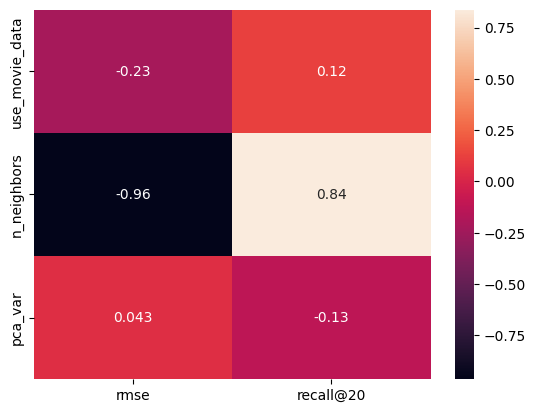

In [48]:
import seaborn as sns
corr = results_df.corr()[["rmse", "recall@20"]].loc[["use_movie_data", "n_neighbors", "pca_var"]]
sns.heatmap(corr, annot=True)
plt.show()

## Making recommendations

In [49]:
train_df_B = pd.read_csv(str(data_folder / "ub.base"), sep="\t", names=data_col_names, encoding='latin-1')
test_df_B = pd.read_csv(str(data_folder / "ub.test"), sep="\t", names=data_col_names, encoding='latin-1')
movie_data = pd.read_csv(str(data_folder / "u.item"), sep="|", names=movie_data_col_names, encoding='latin-1')

recsys = CollaborativeFilteringRecSys(pca_var=0.9, knn_neighbors=600)
recsys.fit(train_df_B, movie_data)

In [50]:
import pickle


with open("recsys.pkl", "wb") as f:
    pickle.dump(recsys, f)

### Evaluation

In [51]:
evaluation_user_list = test_df_B["user_id"].unique()

ks = [10, 20, 50]
scores = {
    "RMSE": [],
    "MAE": []
}
for k in ks:
    scores[f"Presicion@{k}"] = []
    scores[f"Recall@{k}"] = []

for user_id in tqdm(evaluation_user_list):
    preds = recsys.predict_unseen(user_id, verbose=False)
    true_data = test_df_B[["movie_id", "rating"]][test_df_B["user_id"] == user_id]

    scores["RMSE"].append(rmse(true_data, preds))
    scores["MAE"].append(mae(true_data, preds))
    for k in ks:
        p, r = presicion_recall(true_data, preds, k=k)
        if p is not None:
            scores[f"Presicion@{k}"].append(p)
            scores[f"Recall@{k}"].append(r)

100%|██████████| 943/943 [12:37<00:00,  1.25it/s]


In [52]:
for score, score_data in scores.items():
    print(f"{score}:\t{np.mean(score_data):.3f}")

RMSE:	0.999
MAE:	0.796
Presicion@10:	0.019
Recall@10:	0.031
Presicion@20:	0.017
Recall@20:	0.061
Presicion@50:	0.016
Recall@50:	0.140
